In [1]:
import time
start_time=time.time()

In [2]:
from pathlib import Path
from matplotlib import pyplot as plt
import numpy as np
import json
import cmasher as cmr
import seaborn as sns
import sys

from astropy.io import fits
from astropy.utils.misc import JsonCustomEncoder
import astropy.units as u

from turbustat.simulator import make_ppv
from turb_utils import make_extended, make_3dfield

from spectral_cube import SpectralCube  

import pylab as pl

from astropy.convolution import Gaussian2DKernel, convolve_fft

import strucfunc
import sbfluct
from rebin_utils import downsample, oversample
from astropy.modeling import models, fitting
fitter = fitting.LevMarLSQFitter()

## 3D non-tapered maps

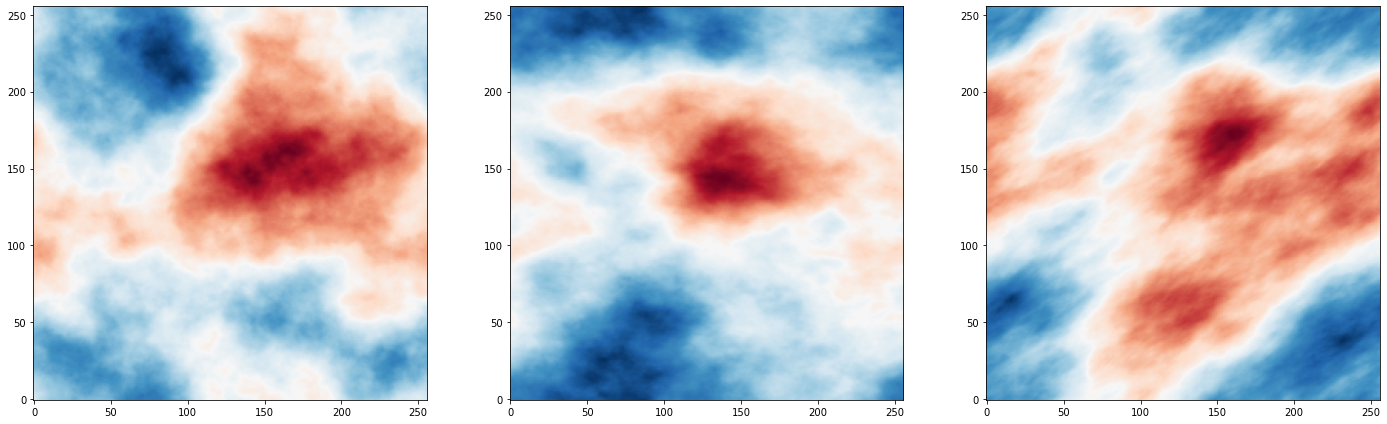

In [3]:
r0 = 32.0
N = 256
m = 1.0

threeD_field_nt = make_3dfield(
    N,
    amp = 1.0,
    ellip=0.5,
    theta=45,
    powerlaw=3.0 + m,
    randomseed=2021_10_08)

plt.figure(figsize=[20, 6])  
plt.subplot(131)  
plt.imshow(threeD_field_nt.mean(0), origin='lower', cmap="RdBu_r")  
plt.subplot(132)  
plt.imshow(threeD_field_nt.mean(1), origin='lower',cmap="RdBu_r")  
plt.subplot(133)  
plt.imshow(threeD_field_nt.mean(2), origin='lower',cmap="RdBu_r")  
plt.tight_layout()  

## 3D tapered maps

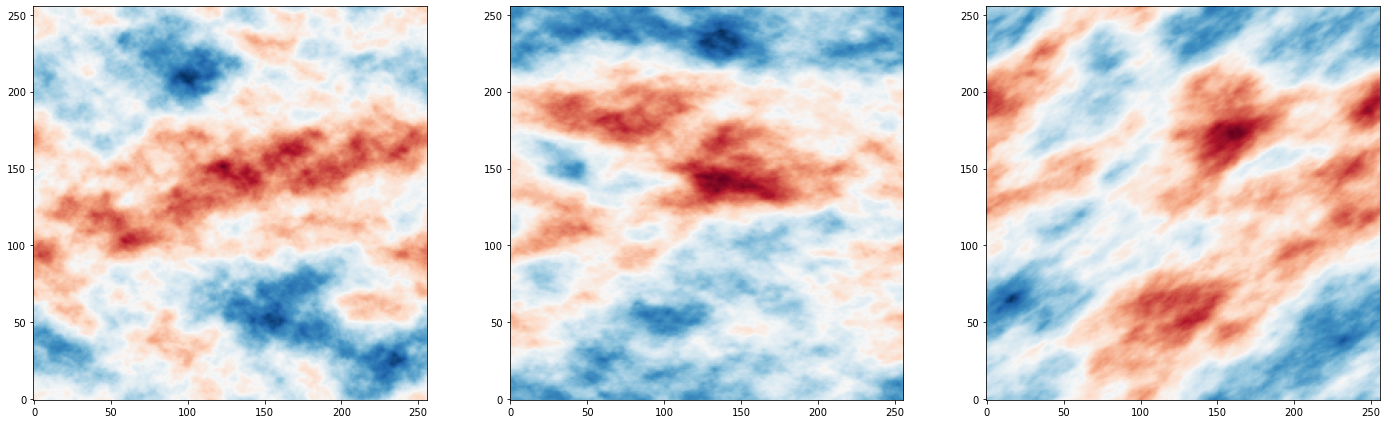

In [4]:
threeD_field = make_3dfield(
    N,
    ellip=0.5,
    theta=45,
    correlation_length=r0,  
    powerlaw=3.0 + m,
    randomseed=2021_10_08)

plt.figure(figsize=[20, 6])  
plt.subplot(131)  
plt.imshow(threeD_field.mean(0), origin='lower',cmap="RdBu_r")  
plt.subplot(132)  
plt.imshow(threeD_field.mean(1), origin='lower',cmap="RdBu_r")  
plt.subplot(133)  
plt.imshow(threeD_field.mean(2), origin='lower',cmap="RdBu_r")  
plt.tight_layout()  

### PPV

non-tapered

In [5]:
velocity_nt = make_3dfield(
    N,
    ellip=0.5,
    theta=45,  
    powerlaw=3.0 + m,
    randomseed=2021_10_08)* u.km / u.s 

tapered

In [6]:
velocity = make_3dfield(
    N,
    ellip=0.5,
    theta=45,
    correlation_length=r0,  
    powerlaw=3.0 + m,
    randomseed=2021_10_08)* u.km / u.s  

In [9]:
#density = np.ones((N,N,N))* u.cm**-3  
#n = 100
#density = density*n
density = make_3dfield(N, 
                       powerlaw=3.0 + m, 
                       amp=1.,
                       ellip=0.5,
                       theta=45,
                       correlation_length=r0,  
                       randomseed=328764) * u.cm**-3  

density += density.std()  
density[density.value < 0.] = 0. * u.cm**-3  

density = 10**np.log(density.value)* u.cm**-3  

<ipython-input-9-34494121341d>:15: RuntimeWarning: divide by zero encountered in log
  density = 10**np.log(density.value)* u.cm**-3


In [10]:
cube_hdu_nt = make_ppv(velocity_nt, density, los_axis=0,
                    T=10000 * u.K, chan_width=0.5 * u.km / u.s,
                    v_min=-20 * u.km / u.s,
                    v_max=20 * u.km / u.s)  

In [11]:
cube_hdu = make_ppv(velocity, density, los_axis=0,
                    T=10000 * u.K, chan_width=0.5 * u.km / u.s,
                    v_min=-20 * u.km / u.s,
                    v_max=20 * u.km / u.s)  

In [12]:
cube_nt = SpectralCube.read(cube_hdu_nt)  
cube = SpectralCube.read(cube_hdu)  

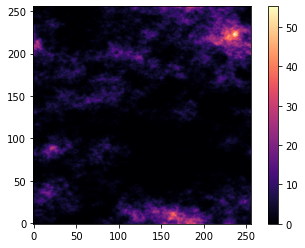

In [13]:
plt.imshow(density[0].value, origin='lower',cmap="magma")  
plt.colorbar() 

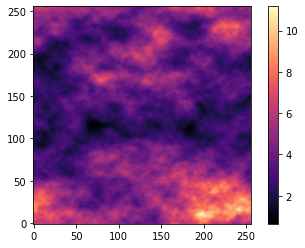

In [14]:
plt.imshow((cube.moment0().value), origin='lower',cmap="magma")  
plt.colorbar() 

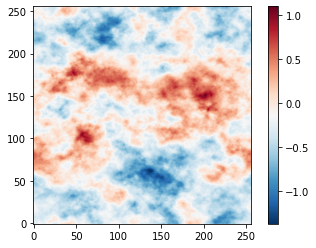

In [15]:
plt.imshow(cube.moment1().value, origin='lower',cmap="RdBu_r")  
plt.colorbar() 

In [16]:
#sb = 10**(cube.moment0().value)
sb = (cube.moment0().value)

In [17]:
fmin = 1e-8
kmax = 2
resamples = [2, 4, 8, 16, 32, 64]

In [18]:
m = (sb > fmin) & np.isfinite(sb)
w = np.ones_like(sb)

In [19]:
for n in resamples[: kmax]:
    [sb,], m, w = downsample([sb,],
        m,
        weights=w,
        mingood=1,
        )
    
sb /= np.mean(sb[m])

In [20]:
smin, smax = -3.1, 3.1

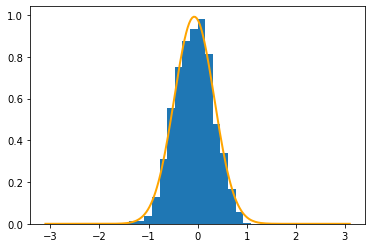

In [21]:
H, edges, patches = plt.hist(
            np.log(sb[m]),
            # weights=s[m],
            density=True,
            bins=40,
            range=[-3.1, 3.1],)

# Calculate bin centers
x = 0.5 * (edges[:-1] + edges[1:])
# Fit Gaussian
g = models.Gaussian1D(amplitude=H.max(), stddev=0.5)
core = H > 0.01
g = fitter(g, x, H)
sigS = np.sqrt(np.exp(g.stddev.value ** 2) - 1)
esigS = 0.5 * np.sqrt(np.exp(g.mean.value ** 2) - 1)
xx = np.linspace(smin, smax, 200)

plt.plot(xx, g(xx), "orange", lw=2)


In [22]:
X = np.exp(xx)
Xmean = np.average(X, weights=g(xx))
Xvariance = np.average((X - Xmean) ** 2, weights=g(xx))
eps_rms = np.sqrt(Xvariance) / Xmean
eps_rms 

0.4252228886571863

In [ ]:
r0 = 32.0
N = 256
m = 1.0

### Slices + seeing

First Im smoothing a single channel to see what to expect

In [ ]:
#pl.imshow(cube[0].value, origin='lower',cmap="RdBu_r")


In [23]:
vmap = cube[0].value

widths = [1, 2, 4, 8, 16, 32]
vmaps = {}
for width in widths:
    kernel = Gaussian2DKernel(x_stddev=width)
    vmaps[width] = convolve_fft(vmap, kernel)

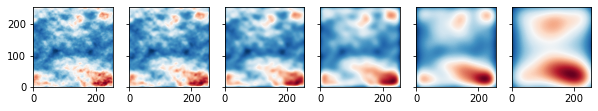

In [24]:
ncols = len(widths)
fig, axgrid = plt.subplots(
    1,
    ncols,
    figsize=(10, 5),
    sharex=True,
    sharey=True,
)

for ax, width in zip(axgrid, widths):
    im = ax.imshow(
        vmaps[width],
        origin="lower",
        #vmin=-2.5,
        #vmax=2.5,
        cmap="RdBu_r",
    )



Now we smooth the cubes and the channels in each cube

In [25]:
##This function computes the smoothing for all the channels

vcubes_new = {}
for width in widths:
    kernel = Gaussian2DKernel(x_stddev=width)
    vcubes_new[width] = cube.spatial_smooth(kernel)

In [26]:
#new_cube = cube.spatial_smooth(kernel)
#pl.imshow(new_cube[1].value, origin='lower',cmap="RdBu_r")


In [27]:
vcubes_new

{1: SpectralCube with shape=(80, 256, 256) and unit=K:
  n_x:    256  type_x: GLON-CAR  unit_x: deg    range:     2.116667 deg:  357.866667 deg
  n_y:    256  type_y: GLAT-CAR  unit_y: deg    range:    -2.116667 deg:    2.133333 deg
  n_s:     80  type_s: VRAD      unit_s: km / s  range:      -19.750 km / s:      19.750 km / s,
 2: SpectralCube with shape=(80, 256, 256) and unit=K:
  n_x:    256  type_x: GLON-CAR  unit_x: deg    range:     2.116667 deg:  357.866667 deg
  n_y:    256  type_y: GLAT-CAR  unit_y: deg    range:    -2.116667 deg:    2.133333 deg
  n_s:     80  type_s: VRAD      unit_s: km / s  range:      -19.750 km / s:      19.750 km / s,
 4: SpectralCube with shape=(80, 256, 256) and unit=K:
  n_x:    256  type_x: GLON-CAR  unit_x: deg    range:     2.116667 deg:  357.866667 deg
  n_y:    256  type_y: GLAT-CAR  unit_y: deg    range:    -2.116667 deg:    2.133333 deg
  n_s:     80  type_s: VRAD      unit_s: km / s  range:      -19.750 km / s:      19.750 km / s,
 8: Spectr

In [28]:
vcubes_new[1]

SpectralCube with shape=(80, 256, 256) and unit=K:
 n_x:    256  type_x: GLON-CAR  unit_x: deg    range:     2.116667 deg:  357.866667 deg
 n_y:    256  type_y: GLAT-CAR  unit_y: deg    range:    -2.116667 deg:    2.133333 deg
 n_s:     80  type_s: VRAD      unit_s: km / s  range:      -19.750 km / s:      19.750 km / s

Here showing some smoothed channels to verify everything is OK

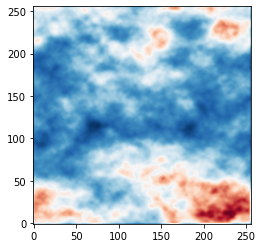

In [29]:
pl.imshow(vcubes_new[1][0].value, origin='lower',cmap="RdBu_r")


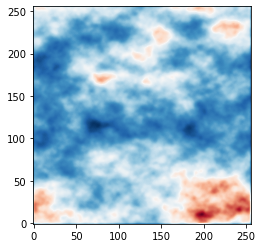

In [30]:
pl.imshow(vcubes_new[1][50].value, origin='lower',cmap="RdBu_r")


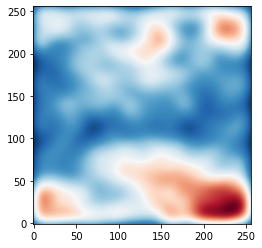

In [31]:
pl.imshow(vcubes_new[8][0].value, origin='lower',cmap="RdBu_r")


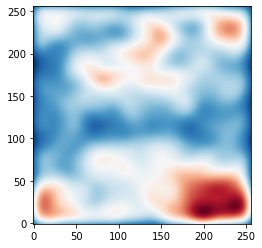

In [32]:
pl.imshow(vcubes_new[8][50].value, origin='lower',cmap="RdBu_r")


### moment1 maps  for the smoothed cubes


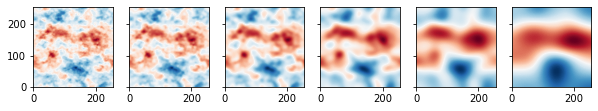

In [33]:
ncols = len(widths)
fig, axgrid = plt.subplots(
    1,
    ncols,
    figsize=(10, 5),
    sharex=True,
    sharey=True,
)

for ax, width in zip(axgrid, widths):
    im = ax.imshow(
        vcubes_new[width].moment1().value  ,
        origin="lower",
        cmap="RdBu_r",
    )

Now we calculate the structure function for each moment1 map

In [34]:
sf0 = strucfunc.strucfunc_numba_parallel(cube_nt.moment1().value,  wmap=cube_nt.moment0().value, dlogr=0.05)



C:\Users\ZAINTEL2\Documents\Aeon\GitHub\PhD.Paper\Fake-Maps\strucfunc.py:81: RuntimeWarning: invalid value encountered in true_divide
  'Unweighted B(r)': sf/nsf,
C:\Users\ZAINTEL2\Documents\Aeon\GitHub\PhD.Paper\Fake-Maps\strucfunc.py:82: RuntimeWarning: invalid value encountered in true_divide
  'Weighted B(r)': wsf/weight}


In [ ]:
#sf0['Unweighted B(r)'] = sf0['Unweighted B(r)'] / (cube_nt.moment1().value).var()

In [35]:
sf = strucfunc.strucfunc_numba_parallel(cube.moment1().value, wmap=cube.moment0().value, dlogr=0.05)

C:\Users\ZAINTEL2\Documents\Aeon\GitHub\PhD.Paper\Fake-Maps\strucfunc.py:81: RuntimeWarning: invalid value encountered in true_divide
  'Unweighted B(r)': sf/nsf,
C:\Users\ZAINTEL2\Documents\Aeon\GitHub\PhD.Paper\Fake-Maps\strucfunc.py:82: RuntimeWarning: invalid value encountered in true_divide
  'Weighted B(r)': wsf/weight}


In [ ]:
#sf['Unweighted B(r)'] = sf['Unweighted B(r)'] / (cube.moment1().value).var()

In [36]:
def normalize(arr):
    return (arr - np.mean(arr)) / np.std(arr)

In [37]:
for width in widths:
    print ( (vcubes_new[width].moment1().value).var() )

0.12128614501140975
0.11615110494564189
0.10525874974354124
0.08619095573610965
0.05998433501629298
0.029475618659442808


[None, None]

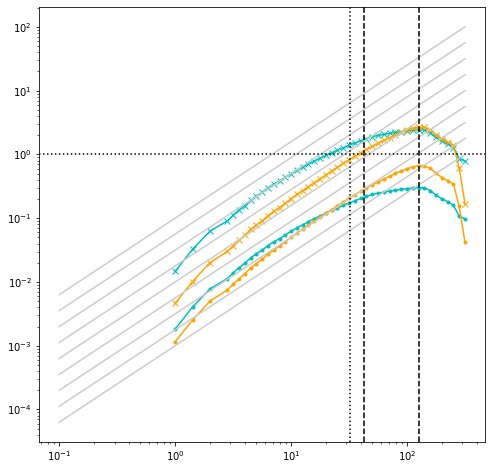

In [42]:
fig, ax = plt.subplots(
    figsize=(8, 8),
)
mask = sf["N pairs"] > 0
r = 10 ** sf["log10 r"][mask]
B = sf["Unweighted B(r)"][mask]
B0 = sf0["Unweighted B(r)"][mask]

#non-normalized
ax.plot(r, B, marker=".", color="c")
ax.plot(r, B0, marker=".", color="orange")
#normalized
ax.plot(r, B/ (cube.moment1().value).var(), marker="x", color="c")
ax.plot(r, B0/ (cube_nt.moment1().value).var(), marker="x", color="orange")


rgrid = np.logspace(-1.0, 2.5)
for a in np.logspace(-3, -1, 9):
    ax.plot(rgrid, a * rgrid ** 1.2, color="0.8")

ax.axhline(1.0, color="k", linestyle="dotted")
ax.axvline(r0, color="k", linestyle="dotted")
ax.axvline(N / 2, color="k", linestyle="dashed")
ax.axvline(N / 6, color="k", linestyle="dashed")
ax.set(xscale="log", yscale="log", 
       #xlim=[1.0, N], ylim=[7e-3, 4.0]
      )

In [39]:
sfs = {}
for width in widths:
    sfs[width] = strucfunc.strucfunc_numba_parallel(
        vcubes_new[width].moment1().value,
        wmap=vcubes_new[width].moment0().value,
        dlogr=0.05,
    )

C:\Users\ZAINTEL2\Documents\Aeon\GitHub\PhD.Paper\Fake-Maps\strucfunc.py:81: RuntimeWarning: invalid value encountered in true_divide
  'Unweighted B(r)': sf/nsf,
C:\Users\ZAINTEL2\Documents\Aeon\GitHub\PhD.Paper\Fake-Maps\strucfunc.py:82: RuntimeWarning: invalid value encountered in true_divide
  'Weighted B(r)': wsf/weight}
C:\Users\ZAINTEL2\Documents\Aeon\GitHub\PhD.Paper\Fake-Maps\strucfunc.py:81: RuntimeWarning: invalid value encountered in true_divide
  'Unweighted B(r)': sf/nsf,
C:\Users\ZAINTEL2\Documents\Aeon\GitHub\PhD.Paper\Fake-Maps\strucfunc.py:82: RuntimeWarning: invalid value encountered in true_divide
  'Weighted B(r)': wsf/weight}
C:\Users\ZAINTEL2\Documents\Aeon\GitHub\PhD.Paper\Fake-Maps\strucfunc.py:81: RuntimeWarning: invalid value encountered in true_divide
  'Unweighted B(r)': sf/nsf,
C:\Users\ZAINTEL2\Documents\Aeon\GitHub\PhD.Paper\Fake-Maps\strucfunc.py:82: RuntimeWarning: invalid value encountered in true_divide
  'Weighted B(r)': wsf/weight}
C:\Users\ZAINTEL

In [ ]:
#for width in widths:
#    sfs[width]['Unweighted B(r)'] =  sfs[width]['Unweighted B(r)'] / (vcubes_new[width].moment1().value).var()
    

Normailzed structure functions

[None, (0.007, 4.0), None, (1.0, 256)]

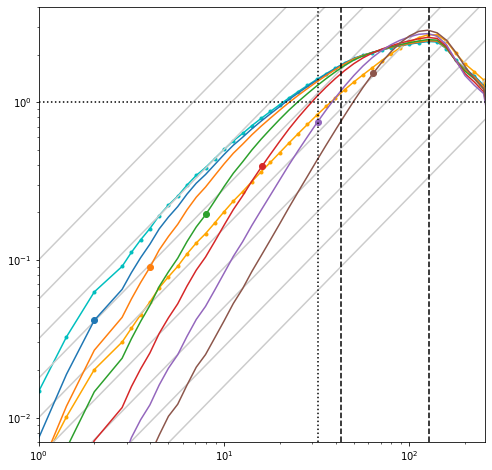

In [43]:
fig, ax = plt.subplots(
    figsize=(8, 8),
)
mask = sf["N pairs"] > 0
r = 10 ** sf["log10 r"][mask]
B = sf["Unweighted B(r)"][mask]/ (cube.moment1().value).var()
B0 = sf0["Unweighted B(r)"][mask]/ (cube_nt.moment1().value).var()

ax.plot(r, B, marker=".", color="c")
ax.plot(r, B0, marker=".", color="orange")

rgrid = np.logspace(-1.0, 2.5)
for a in np.logspace(-3, -1, 9):
    ax.plot(rgrid, a * rgrid ** 1.2, color="0.8")

for width in widths:
    r = 10 ** sfs[width]["log10 r"][mask]
    B = sfs[width]["Unweighted B(r)"][mask] / (vcubes_new[width].moment1().value).var()
    line = ax.plot(r, B)
    B0 = np.interp(2 * width, r, B)
    c = line[0].get_color()
    ax.plot(2 * width, B0, marker="o", color=c)


ax.axhline(1.0, color="k", linestyle="dotted")
ax.axvline(r0, color="k", linestyle="dotted")
ax.axvline(N / 2, color="k", linestyle="dashed")
ax.axvline(N / 6, color="k", linestyle="dashed")
ax.set(xscale="log", yscale="log", xlim=[1.0, N], ylim=[7e-3, 4.0])

Non-Normailzed structure functions

[None, (7e-05, 1.5), None, (1.0, 256)]

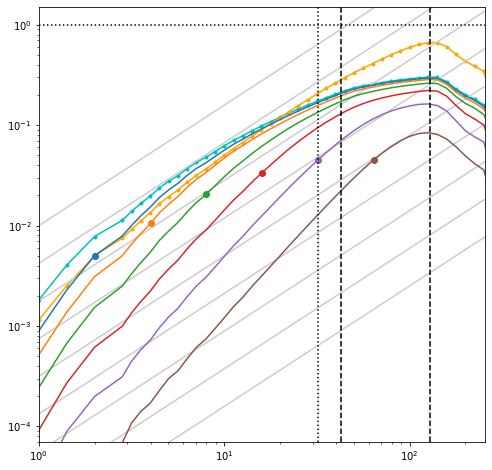

In [45]:
fig, ax = plt.subplots(
    figsize=(8, 8),
)
mask = sf["N pairs"] > 0
r = 10 ** sf["log10 r"][mask]
B = sf["Unweighted B(r)"][mask]
B0 = sf0["Unweighted B(r)"][mask]

ax.plot(r, B, marker=".", color="c")
ax.plot(r, B0, marker=".", color="orange")

rgrid = np.logspace(-1.0, 2.5)
for a in np.logspace(-5, -2, 9):
    ax.plot(rgrid, a * rgrid ** 1.2, color="0.8")

for width in widths:
    r = 10 ** sfs[width]["log10 r"][mask]
    B = sfs[width]["Unweighted B(r)"][mask] 
    line = ax.plot(r, B)
    B0 = np.interp(2 * width, r, B)
    c = line[0].get_color()
    ax.plot(2 * width, B0, marker="o", color=c)


ax.axhline(1.0, color="k", linestyle="dotted")
ax.axvline(r0, color="k", linestyle="dotted")
ax.axvline(N / 2, color="k", linestyle="dashed")
ax.axvline(N / 6, color="k", linestyle="dashed")
ax.set(xscale="log", yscale="log", xlim=[1.0, N], ylim=[7e-5, 1.5])

### Ratio of smoothed to unsmoothed

In [ ]:
#sns.set_color_codes()
#sns.set_context("talk")

In [46]:
def ratio_empirical(rad, s0, a=1.0):
    """
    Simple tanh law in semi-log space to fit the seeing

    Reduction in B(r) is always 0.5 when r = 2 * s0
    Parameter `a` controls the slope of the transition.
    """
    x = np.log(rad / (2 * s0))
    y = np.tanh(a * x)
    return 0.5 * (1.0 + y)


def bfac(x):
    """
    Across-the board reduction in B(r) for x = s0 / r0

    Where s0 is RMS seeing width and r0 is correlation length
    """
    return 1 / (1 + 4 * x ** 2)


def seeing_empirical(r, s0, r0, a=0.75):
    return bfac(s0 / r0) * ratio_empirical(r, s0, a)

[None, None]

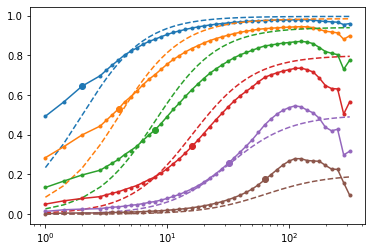

In [47]:
fig, ax = plt.subplots()
B0 = sf["Unweighted B(r)"][mask]
for width in widths:
    r = 10 ** sfs[width]["log10 r"][mask]
    B = sfs[width]["Unweighted B(r)"][mask]
    rat = B / B0
    line = ax.plot(
        r,
        rat,
        marker=".",
    )
    rat0 = np.interp(2 * width, r, rat)
    c = line[0].get_color()
    ax.plot(2 * width, rat0, marker="o", color=c)
    # Functional fit
    ax.plot(r, seeing_empirical(r, width, r0, 0.85), color=c, linestyle="dashed")
ax.set(xscale="log", yscale="linear")

In [ ]:
maps_moment1 = {}
maps_moment1['nt'] = cube_nt.moment1().value
maps_moment1[0] = cube.moment1().value
maps_moment1[1] = vcubes_new[1].moment1().value 
maps_moment1[2] = vcubes_new[2].moment1().value 
maps_moment1[4] = vcubes_new[4].moment1().value 
maps_moment1[8] = vcubes_new[8].moment1().value 
maps_moment1[16] = vcubes_new[16].moment1().value 
maps_moment1[32] = vcubes_new[32].moment1().value 

In [ ]:
#maps_moment1

In [ ]:
class MyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(MyEncoder, self).default(obj)

In [ ]:
#jsonfilename = "maps_moment1_emfluc.json"
#with open(jsonfilename, "w") as f:
#    json.dump(maps_moment1_emfluc, fp=f, indent=3, cls=MyEncoder)

In [ ]:
!jupyter nbconvert --to script --no-prompt fake-3d-tapered-emissivity-fluct.ipynb

In [ ]:
print("--- %s seconds ---" % (time.time()-start_time))